# INTRODUCTION

In [1]:
# Read in data and packages
import pandas as pd
import numpy as np
#import bamboolib as bam
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, f1_score

df = pd.read_csv('ML1_data_adj_v2.csv')

The response variable for this classification analysis will be Fwd_Return_3M_Class, which represents the forward / future 3 month return of a given stock in our dataset relative to the 3 month return of the equal weighted S&P 500 index.  This captures whether a stock is deemed to have out- or under-performed during this time period.

In [2]:
# X variables = explanatory variables
X = df.drop(columns=['Date', 'ticker', 'Year', 'Fwd_ST_Accel_Class_3M', 'Fwd_Return_3M_Class', 'Fwd_Return_6M_Class', 'Fwd_Best_EPS_6M', 'Fwd_ST_Accel_3M','Sector','Fwd_Best_EPS_6M_v5Y', 'Fwd_Return_6M', 'Fwd_Return_3M', 'Fwd_Return_1M'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mkt_Cap                52663 non-null  float64
 1   Best_EPS_1M            52663 non-null  float64
 2   Best_EPS_3M            52663 non-null  float64
 3   Best_EPS_6M            52663 non-null  float64
 4   Best_EPS_1Y            52663 non-null  float64
 5   Best_EPS_3Y            52663 non-null  float64
 6   Best_EPS_5Y            52663 non-null  float64
 7   Best_EPS_3M_v5Y        52663 non-null  float64
 8   Best_EPS_6M_v5Y        52663 non-null  float64
 9   Best_EPS_1Y_v5Y        52663 non-null  float64
 10  Best_EPS_3Y_v5Y        52663 non-null  float64
 11  Best_EPS_3M_Rank       52663 non-null  float64
 12  Best_EPS_6M_Rank       52663 non-null  float64
 13  Best_EPS_1Y_Rank       52663 non-null  float64
 14  ST_Accel               52663 non-null  float64
 15  ST

In [3]:
# y = response variable
y = df[['Fwd_Return_3M_Class']]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Fwd_Return_3M_Class  52663 non-null  int64
dtypes: int64(1)
memory usage: 411.6 KB


In [4]:
# We will use this object later on.
X_imputed = X

In [5]:
# Assess balance of data set
y.groupby(['Fwd_Return_3M_Class']).size().reset_index(name='counts')

,Fwd_Return_3M_Class,counts
0,0,23362
1,1,29301


# LOGISTIC REGRESSION MODELLING

As part of our logistic regression model building efforts, we built several models and sought to adjust parameters with the end goal in mind of improving accuracy, F1 score and AUC.  We built a model that included all of the variables and adjusted parameters to improve accuracy, then assessed the power of each of the variables (as detailed in forthcoming sections below).  With this information we then built two models based on feature importance weight thresholds of 0.1 and 0.3.  Then we built a dimension reduction model using PCA.

Upon completion of our model building efforts, we chose Model 2 as our finalized logistic regression model given it captured the superior power evidenced in Model 1 with less complexity / variables needed.  This feature reduction model chose features based on a threshold of 0.1.  Note, we set the penalty term to "l2", C to 0.05 and the algorithm used to optimize the problem (i.e. the solver) was liblinear.  We also set class_weight to "balanced" as we found our initial outputs resulting in positively skewed predictions.  Details on such model building efforts is as follows:

## MODEL 1

Includes all explanatory variables

In [6]:
# MODEL 1

# Import needed packages
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Test train split 
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
# Check balance of dependent variables
y_train.groupby(['Fwd_Return_3M_Class']).size().reset_index(name='counts')

,Fwd_Return_3M_Class,counts
0,0,18747
1,1,23383


In [8]:
y_test.groupby(['Fwd_Return_3M_Class']).size().reset_index(name='counts')

,Fwd_Return_3M_Class,counts
0,0,4615
1,1,5918


In [9]:
# Normalize / scale variables
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

In [10]:
# train the model 

# Model 1
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear', class_weight="balanced") 

In [11]:
# Start clock / time to run one logistic regression model code
import time
start_time = time.time()

# Train object
lr_clf.fit(X_train_scaled,y_train.values.ravel())  

# Get test set predictions
y_hat = lr_clf.predict(X_test_scaled) 

# Accuracy
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y_test, y_hat)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y_test, y_hat)
print('AUC:', auc )

# Print time to run model code
print("--- %s seconds ---" % (time.time() - start_time))

accuracy: 0.5497009399031615
[[2536 2079]
 [2664 3254]]
F1 score: 0.5784374722246911
AUC: 0.5496801904833739
--- 1.7768828868865967 seconds ---


## MODEL 2 & 3

Alternate logistic regression models using feature reduction.

Model 2 uses feature importance weights for explanatory variables >= 0.1.

Model 3 uses feature importance weights for explanatory variables >= 0.3.

Although Model 2 reduces the amount of explanatory variables and to those with higher weights and incrementally improves the speed of the model calculation, there is a slight reduction to accuracy.  And given the speed differential is minimal, as mentioned above, we chose Model 1 as our final logistic regression model.

In [12]:
#MODEL 2
#explanatory variables for feature reduction model
# Selected by weights greater than .1
X2 = df[['An_Down_6M','Best_EPS_6M_Rank', 'Best_EPS_1Y_Rank', 'An_Mark_6M','An_Unch_6M','An_Unch','NRR',
        'An_Mark','An_Down','Best_EPS_5Y_R2_Rank','Best_EPS_3Y_R2','Best_EPS_Mean_Med','Best_EPS_Hi_Lo','Best_EPS_Sigma_1Y',
        'ROIC']]

X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   An_Down_6M           52663 non-null  float64
 1   Best_EPS_6M_Rank     52663 non-null  float64
 2   Best_EPS_1Y_Rank     52663 non-null  float64
 3   An_Mark_6M           52663 non-null  float64
 4   An_Unch_6M           52663 non-null  float64
 5   An_Unch              52663 non-null  float64
 6   NRR                  52663 non-null  float64
 7   An_Mark              52663 non-null  float64
 8   An_Down              52663 non-null  float64
 9   Best_EPS_5Y_R2_Rank  52663 non-null  float64
 10  Best_EPS_3Y_R2       52663 non-null  float64
 11  Best_EPS_Mean_Med    52663 non-null  float64
 12  Best_EPS_Hi_Lo       52663 non-null  float64
 13  Best_EPS_Sigma_1Y    52663 non-null  float64
 14  ROIC                 52663 non-null  float64
dtypes: float64(15)
memory usage: 6.0 MB


In [13]:
# y = response variable
y2 = df[['Fwd_Return_3M_Class']]
y2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Fwd_Return_3M_Class  52663 non-null  int64
dtypes: int64(1)
memory usage: 411.6 KB


In [14]:
# Logistical Regression Object
lr_clf2 = LogisticRegression(penalty='l2', C=1.0, class_weight="balanced", solver='liblinear', random_state=123) 

In [15]:
# Test train split 
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

In [16]:
# scale attributes by the training set
scl_obj2 = StandardScaler()
scl_obj2.fit(X2_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled2 = scl_obj2.transform(X2_train) # apply to training
X_test_scaled2 = scl_obj2.transform(X2_test) # apply those means and std to the test set (without snooping at the test set values)

In [17]:
# Start clock / time to run one logistic regression model code
import time
start_time = time.time()

# Train object
lr_clf2.fit(X_train_scaled2,y2_train.values.ravel())  

# Get test set predictions
y_hat2 = lr_clf2.predict(X_test_scaled2) 

# Accuracy
acc = mt.accuracy_score(y2_test,y_hat2)
conf = mt.confusion_matrix(y2_test,y_hat2)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y2_test, y_hat2)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y2_test, y_hat2)
print('AUC:', auc )

# Print time to run model code
print("--- %s seconds ---" % (time.time() - start_time))

accuracy: 0.5475173264976739
[[2478 2137]
 [2629 3289]]
F1 score: 0.5798660084626234
AUC: 0.5463534135899181
--- 0.15857815742492676 seconds ---


In [18]:
#MODEL 3
#explanatory variables for feature reduction model
# Selected by weights greater than .3
X3 = df[['An_Down_6M', 'Best_EPS_1Y_Rank', 'An_Mark_6M',
        'An_Mark','An_Down','Best_EPS_5Y_R2_Rank','Best_EPS_3Y_R2','Best_EPS_Mean_Med','Best_EPS_Hi_Lo','Best_EPS_Sigma_1Y',
        'ROIC']]

X3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   An_Down_6M           52663 non-null  float64
 1   Best_EPS_1Y_Rank     52663 non-null  float64
 2   An_Mark_6M           52663 non-null  float64
 3   An_Mark              52663 non-null  float64
 4   An_Down              52663 non-null  float64
 5   Best_EPS_5Y_R2_Rank  52663 non-null  float64
 6   Best_EPS_3Y_R2       52663 non-null  float64
 7   Best_EPS_Mean_Med    52663 non-null  float64
 8   Best_EPS_Hi_Lo       52663 non-null  float64
 9   Best_EPS_Sigma_1Y    52663 non-null  float64
 10  ROIC                 52663 non-null  float64
dtypes: float64(11)
memory usage: 4.4 MB


In [19]:
# y = response variable
y3 = df[['Fwd_Return_3M_Class']]
y3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Fwd_Return_3M_Class  52663 non-null  int64
dtypes: int64(1)
memory usage: 411.6 KB


In [20]:
# Logistical Regression Object
lr_clf3 = LogisticRegression(penalty='l2', C=1.0, class_weight="balanced", solver='liblinear', random_state=123) 

In [21]:
# Test train split 
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=123)

In [22]:
# scale attributes by the training set
scl_obj3 = StandardScaler()
scl_obj3.fit(X3_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled3 = scl_obj3.transform(X3_train) # apply to training
X_test_scaled3 = scl_obj3.transform(X3_test) # apply those means and std to the test set (without snooping at the test set values)

In [23]:
# Start clock / time to run one logistic regression model code
import time
start_time = time.time()

# Train object
lr_clf3.fit(X_train_scaled3,y3_train.values.ravel())  

# Get test set predictions
y_hat3 = lr_clf3.predict(X_test_scaled3) 

# Accuracy
acc = mt.accuracy_score(y3_test,y_hat3)
conf = mt.confusion_matrix(y3_test,y_hat3)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y3_test, y_hat3)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y3_test, y_hat3)
print('AUC:', auc )

# Print time to run model code
print("--- %s seconds ---" % (time.time() - start_time))

accuracy: 0.5381182948827494
[[2411 2204]
 [2661 3257]]
F1 score: 0.5724580367343352
AUC: 0.5363908592585486
--- 0.05707120895385742 seconds ---


## MODEL 4

Model 4 uses dimension reduction / PCA to build the explanatory variables.  Upon running our PCA analysis, we chose to use 10 principle components in our model based on the results of the scree plot which should this amount captured nearly 100% of the total variance.


Eigenvalues:
[4.17998999e+00 2.32216808e+00 2.00281699e+00 1.84349987e+00
 1.07838281e+00 9.62395946e-01 9.19740332e-01 6.02294977e-01
 5.02452108e-01 3.30426015e-01 2.39824046e-01 7.51204665e-03
 5.96588549e-03 1.85253578e-03 9.63204410e-04]

Variances (Percentage):
[2.78660708e+01 1.54808266e+01 1.33518597e+01 1.22897658e+01
 7.18908222e+00 6.41585114e+00 6.13148578e+00 4.01522360e+00
 3.34961711e+00 2.20279827e+00 1.59879661e+00 5.00793601e-02
 3.97718147e-02 1.23500040e-02 6.42124080e-03]



Text(0, 0.5, 'Explained variance (%)')

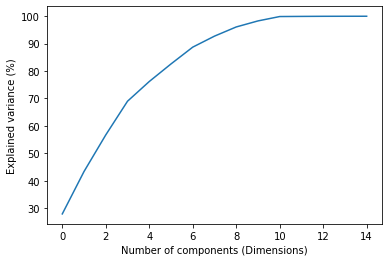

In [24]:
from matplotlib import pyplot

# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X2)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
pyplot.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
pyplot.xlabel("Number of components (Dimensions)")
pyplot.ylabel("Explained variance (%)")

In [25]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X2)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca)
print(X_pca.head())
print("\nSize: ")
print(X_pca.shape)

          0         1         2         3         4         5         6  \
0 -0.268409  1.273752 -1.008550 -0.071486 -1.297822  1.137634  0.003183   
1  4.393952 -1.949254 -0.755515 -0.172601  3.400657  0.310062  1.713363   
2 -0.694271  1.550715  1.047877  1.099140  0.513444 -0.418342 -1.015187   
3  0.993207 -1.655574 -0.745595 -0.597915  0.352893  0.365016 -0.318081   
4 -1.570718 -0.914930  1.250978 -0.131635  0.319105 -0.043232 -0.357801   

          7         8         9  
0  1.896500 -0.399462 -1.315777  
1  0.048878 -1.276809  2.009399  
2  0.480146  0.980311 -0.987108  
3  1.750193 -0.038827 -0.389318  
4 -0.956501 -0.625114  0.598352  

Size: 
(52663, 10)


In [26]:
# y = response variable
y4 = df[['Fwd_Return_3M_Class']]
y4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Fwd_Return_3M_Class  52663 non-null  int64
dtypes: int64(1)
memory usage: 411.6 KB


In [27]:
# Logistical Regression Object
lr_clf4 = LogisticRegression(penalty='l2', C=1.0, class_weight="balanced", solver='liblinear', random_state=123) 

In [28]:
# Test train split 
X4_train_pca, X4_test_pca, y4_train, y4_test = train_test_split(X_pca, y4, test_size=0.2, random_state=123)

In [29]:
# Start clock / time to run one logistic regression model code
import time
start_time = time.time()

# Train object
lr_clf4.fit(X4_train_pca,y4_train.values.ravel())  

# Get test set predictions
y_hat4 = lr_clf4.predict(X4_test_pca) 

# Accuracy
acc = mt.accuracy_score(y4_test,y_hat4)
conf = mt.confusion_matrix(y4_test,y_hat4)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y4_test, y_hat4)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y4_test, y_hat4)
print('AUC:', auc )

# Print time to run model code
print("--- %s seconds ---" % (time.time() - start_time))

accuracy: 0.5394474508686984
[[2486 2129]
 [2722 3196]]
F1 score: 0.568531530730232
AUC: 0.5393627682333897
--- 0.05408167839050293 seconds ---


### Logistic regression final

As detailed above, after assessing our four models we decided to go with Model 2 which chose features based on a 0.1 threshold. 

In [30]:
# Accuracy
acc = mt.accuracy_score(y2_test,y_hat2)
conf = mt.confusion_matrix(y2_test,y_hat2)
print('accuracy:', acc )
print(conf )

#calculate F1 score
f1 = f1_score(y2_test, y_hat2)
print('F1 score:', f1 )

#calculate AUC
auc = roc_auc_score(y2_test, y_hat2)
print('AUC:', auc )

accuracy: 0.5475173264976739
[[2478 2137]
 [2629 3289]]
F1 score: 0.5798660084626234
AUC: 0.5463534135899181


# LOGISTIC  REGRESSION FEATURE INSIGHT

Upon completion of building and finalizing our logistic modelling efforts, we then sought to explore which features showed the most efficacy on our chosen model.  

The top 5 variables based on absolute values with their respective coefficient are as follows (in order from highest to lowest):

An_Down_6M (0.268)

An_Down (-0.249)

Best_EPS_1Y_Rank (0.180)

An_Mark (0.175)

Best_EPS_Mean_Med (0.171)

Refresher on the definition of each of these variables:
An_Down - This represents the percentage during the past 3 month period of total revisions by the sell side analysts covering a given stock which were negative.
An_Down_6M - This variable seeks to capture the second derivative changes of "An_Down" and is calculated by subtracting the "An_Down" value 6 months ago from the current value.  This helps to determine the overall trend in such negative revisions during this time period.
Best_EPS_1Y_Rank - This represents the rank of a stock in this universe based on the past 1 year growth rate of their median consensus EPS.
An_Mark - This metric came from FactSet and seeks to quantify the relative trend in the analyst revisions with the lower being better.
Best_EPS_Mean_Med - This variable is one we created which seeks to capture the tightness of the consensus estimates and the potential for outliers (both positive and negative) by subtracting the current mean and median consensus EPS values from each other.  

The latter three variables seem to be intuitive with their predictability based on the following:

Based on the concept of momentum (which is the basis of our EPS Estimate Revision MOMENTUM modelling efforts detailed in the prior lab and serves as the same data used in this lab), we were not surprised to see Best_EPS_1Y_Rank showing efficacy and a positive relationship with predicting whether a stock will outperform or not during the next 3 months.  It appears that a 1 year trend is more powerful in it's predictability than both shorter and longer term calculations thus may be a sweet spot of not being too short of a time period which can capture noise in the data and too long term which is not able to capture changes in trend.

Also confirming our thoughts on the subject of the power of EPS revisions on stocks (both their EPS and price trends) was the An_Mark variable which also had a positive relationship showing that it is better for the stock price to have the relative trend of analyst revisions be positive, which thus increases that stock's chance of outperforming during the next 3 months.

The Best_EPS_Mean_Med variables positive relationship interestingly showed a positive relationship which we read to say that positive outliers in EPS consensus estimates are good and vice versa.  For example, if there are at least one EPS estimate that is far from the median and thus pulls the mean value above the median value, then per our model that is a positive signal regarding the stock's probability to outperform during the next 3 months.  Potentially the outlier estimate is more informed about the stock's outlook than the others thus their estimate should be respected and even when it deviates for the rest of the group.

The most complex yet interesting variables were the top two which were An_Down and An_Down_6M which showed positive and negative relationships with the response variable, respectively.  The overall theory we have for this result is based on the emotions of the stock market whereby negative sentiment towards a stock can be extrapolated incorrectly especially in the short term.  To best explain what may be going on with these variables we will provide an example.  Let's assume XYZ stock has a An_Down value of 100 which means that 100% of the analysts have revised their estimates down during the past 3 months.  As such, this is deemed to be negative for the stock price during the next 3 months per our model.  At this same time, let's assume the An_Down_6M value is also 100 which means that the An_Down value 6 months ago was 0 and implies that the negative revisions have taken place in recent months (i.e. this negative trend has not been in place for greater than 6 months).  This implies that the sentiment towards EPS has turned down from where it was more recently.  So how can this be a potential positive for the stock price in the next 3 months?  This goes back to our extrapolation theory that when analysts get too negative too fast in the short term they may have become extrapolated incorrectly and become too pessimistic (and vice versa) in their estimates which the market will self correct by mean reverting the stock during the next 3 months.  

In [31]:
# List out attributes with coefficients for Model 1
zip_vars = zip(lr_clf.coef_.T,X.columns) 
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) 

Mkt_Cap has weight of 0.06339181346896815
Best_EPS_1M has weight of 0.02981940372559301
Best_EPS_3M has weight of 0.07739567412063798
Best_EPS_6M has weight of -0.09810620552400352
Best_EPS_1Y has weight of 0.021654608074385764
Best_EPS_3Y has weight of -0.03397002957007806
Best_EPS_5Y has weight of 0.0542894453710077
Best_EPS_3M_v5Y has weight of -0.031186693275290066
Best_EPS_6M_v5Y has weight of 0.007988678475061793
Best_EPS_1Y_v5Y has weight of 0.07079934752934008
Best_EPS_3Y_v5Y has weight of 0.042300586368622606
Best_EPS_3M_Rank has weight of 0.05138967066047808
Best_EPS_6M_Rank has weight of 0.13303884028329582
Best_EPS_1Y_Rank has weight of -0.17960947094994778
ST_Accel has weight of 0.0022803953095344243
ST_Accel_Class has weight of -0.049082651661175994
NRR_6M has weight of -0.09229040875008288
An_Mark_6M has weight of -0.12977449819621054
An_Unch_6M has weight of 0.14102728063501518
An_Down_6M has weight of 0.2679221216251654
An_Up_6M has weight of 0.08463363671350309
NRR_3M

In [32]:
# List out attributes by numeric identifier to ease interpretation

# get importance
importance = lr_clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.06339
Feature: 1, Score: 0.02982
Feature: 2, Score: 0.07740
Feature: 3, Score: -0.09811
Feature: 4, Score: 0.02165
Feature: 5, Score: -0.03397
Feature: 6, Score: 0.05429
Feature: 7, Score: -0.03119
Feature: 8, Score: 0.00799
Feature: 9, Score: 0.07080
Feature: 10, Score: 0.04230
Feature: 11, Score: 0.05139
Feature: 12, Score: 0.13304
Feature: 13, Score: -0.17961
Feature: 14, Score: 0.00228
Feature: 15, Score: -0.04908
Feature: 16, Score: -0.09229
Feature: 17, Score: -0.12977
Feature: 18, Score: 0.14103
Feature: 19, Score: 0.26792
Feature: 20, Score: 0.08463
Feature: 21, Score: -0.04571
Feature: 22, Score: -0.03193
Feature: 23, Score: -0.02340
Feature: 24, Score: 0.06390
Feature: 25, Score: -0.01887
Feature: 26, Score: 0.10203
Feature: 27, Score: 0.16951
Feature: 28, Score: -0.03618
Feature: 29, Score: -0.24936
Feature: 30, Score: -0.04374
Feature: 31, Score: 0.00193
Feature: 32, Score: 0.01919
Feature: 33, Score: -0.06949
Feature: 34, Score: -0.07802
Feature: 35, S

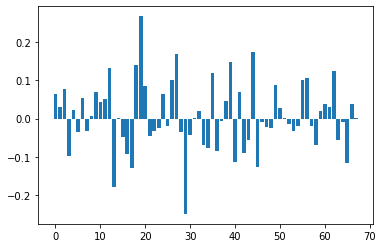

In [33]:
from matplotlib import pyplot

# plot feature importance by numeric identifier to ease interpretation
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [34]:
# helps to see which numbers align with which variable
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52663 entries, 0 to 52662
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mkt_Cap                52663 non-null  float64
 1   Best_EPS_1M            52663 non-null  float64
 2   Best_EPS_3M            52663 non-null  float64
 3   Best_EPS_6M            52663 non-null  float64
 4   Best_EPS_1Y            52663 non-null  float64
 5   Best_EPS_3Y            52663 non-null  float64
 6   Best_EPS_5Y            52663 non-null  float64
 7   Best_EPS_3M_v5Y        52663 non-null  float64
 8   Best_EPS_6M_v5Y        52663 non-null  float64
 9   Best_EPS_1Y_v5Y        52663 non-null  float64
 10  Best_EPS_3Y_v5Y        52663 non-null  float64
 11  Best_EPS_3M_Rank       52663 non-null  float64
 12  Best_EPS_6M_Rank       52663 non-null  float64
 13  Best_EPS_1Y_Rank       52663 non-null  float64
 14  ST_Accel               52663 non-null  float64
 15  ST

# SUPPORT VECTOR MACHINES MODELLING

In [35]:
X_svm = X.values
y_svm = y.values

In [36]:
# Normalize / scale variables
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj5 = StandardScaler()
scl_obj5.fit(X_svm) # find scalings for each column that make this zero mean and unit std

X_scaled = scl_obj5.transform(X_svm) # apply to training

In [37]:
# Import library
from sklearn.svm import SVC

# Train the model
svm_clf = SVC(C=0.05, kernel='rbf', degree=3, gamma='auto', class_weight="balanced") 

# Cross validation object
from sklearn.model_selection import ShuffleSplit

num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2, random_state=123)
                         
print(cv_object)

ShuffleSplit(n_splits=1, random_state=123, test_size=0.2, train_size=None)


In [38]:
# Start clock / time to run one logistic regression model code
import time
start_time = time.time()

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X_scaled,y): 
    X_train = X_scaled[train_indices]
    y_train = y_svm[train_indices]
    
    X_test = X_scaled[test_indices]
    y_test = y_svm[test_indices]
    
    svm_clf.fit(X_train,y_train.ravel())  # train object
    y_hat = svm_clf.predict(X_test) # get test set predictions

    # accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    
    #calculate F1 score
    f1 = f1_score(y_test, y_hat)
    print('F1 score:', f1 )
    
    #calculate AUC
    auc = roc_auc_score(y_test, y_hat)
    print('AUC:', auc )
    
    iter_num+=1
    
# Print time to run model code
print("--- %s seconds ---" % (time.time() - start_time))

====Iteration 0  ====
accuracy 0.5976454951106047
confusion matrix
 [[2798 1817]
 [2421 3497]]
F1 score: 0.6226851851851851
AUC: 0.5985964739485866
--- 229.17084956169128 seconds ---


# SUPPORT VECTOR INSIGHT

In [39]:
# quick look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(40260, 68)
(40260,)
[17928 22332]


As we can see in the cell above, the support vectors are the data points that are close to the hyperplane that influence the position and orientation of the hyperplane; these support vectors maximize the margin of the classifier. These were taken from the model with the highest accuracy, found in the code results above.

In [40]:
# if using linear kernel, these make sense to look at (not otherwise)
# We left this in just to show that it will not work since we used radial basis function
# as our kernel
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=X_imputed.columns)
weights.plot(kind='bar')

AttributeError: coef_ is only available when using a linear kernel

The below cell shows the instances that were chosen as the support vectors. It also might indicate if they are indicative of anything, following our intuition. First, we made a dataframe of the training data, then appended the support vectors from the training model, with the original response variable from the original data. 

In [41]:
df_tested_on = X_imputed.iloc[train_indices].copy()
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['Fwd_Return_3M_Class'] = y_svm[svm_clf.support_]
X_imputed['Fwd_Return_3M_Class'] = y_svm

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40260 entries, 212 to 22241
Data columns (total 69 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mkt_Cap                40260 non-null  float64
 1   Best_EPS_1M            40260 non-null  float64
 2   Best_EPS_3M            40260 non-null  float64
 3   Best_EPS_6M            40260 non-null  float64
 4   Best_EPS_1Y            40260 non-null  float64
 5   Best_EPS_3Y            40260 non-null  float64
 6   Best_EPS_5Y            40260 non-null  float64
 7   Best_EPS_3M_v5Y        40260 non-null  float64
 8   Best_EPS_6M_v5Y        40260 non-null  float64
 9   Best_EPS_1Y_v5Y        40260 non-null  float64
 10  Best_EPS_3Y_v5Y        40260 non-null  float64
 11  Best_EPS_3M_Rank       40260 non-null  float64
 12  Best_EPS_6M_Rank       40260 non-null  float64
 13  Best_EPS_1Y_Rank       40260 non-null  float64
 14  ST_Accel               40260 non-null  float64
 15  

In [42]:
print("Here are the class weights of the linear SVM: {}".format(svm_clf.class_weight_))
print('\n')
print("Here are the classes of the linear SVM: {}".format(svm_clf.classes_))
print('\n')
print("Here are the constants in the decision function of the linear SVM: {}".format(svm_clf.intercept_))
print('\n')
print("Here are the number of feature seen during the fit of of the linear SVM: {}".format(svm_clf.n_features_in_))
print('\n')
print("Here are the indices of support vectors of the linear SVM: {}".format(svm_clf.support_))
print('\n')
print("Here are the number of support vectors for each class of the linear SVM: {}".format(svm_clf.n_support_))
print('\n')
print("Here is the array of dimensions of training vector X of the linear SVM: {}".format(svm_clf.shape_fit_))

Here are the class weights of the linear SVM: [1.12364645 0.90086815]


Here are the classes of the linear SVM: [0 1]


Here are the constants in the decision function of the linear SVM: [-0.06585147]


Here are the number of feature seen during the fit of of the linear SVM: 68


Here are the indices of support vectors of the linear SVM: [    2     8    10 ... 42118 42121 42122]


Here are the number of support vectors for each class of the linear SVM: [17928 22332]


Here is the array of dimensions of training vector X of the linear SVM: (42130, 68)


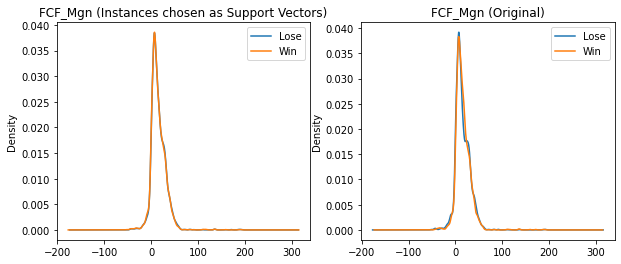

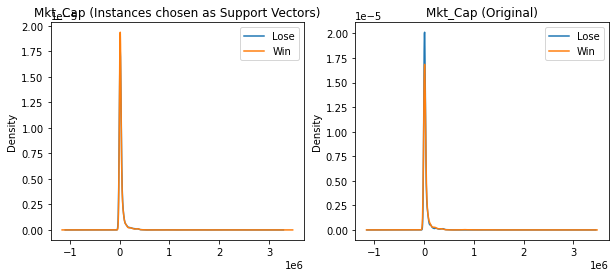

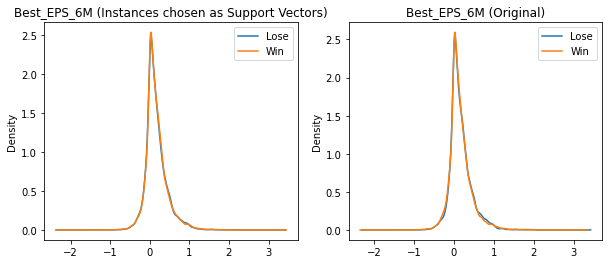

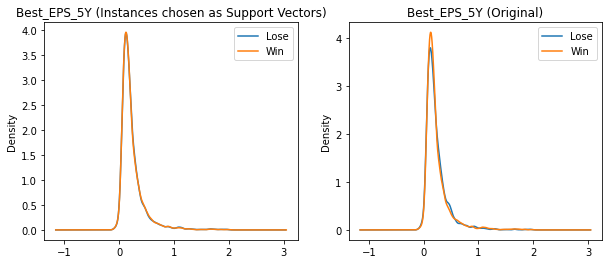

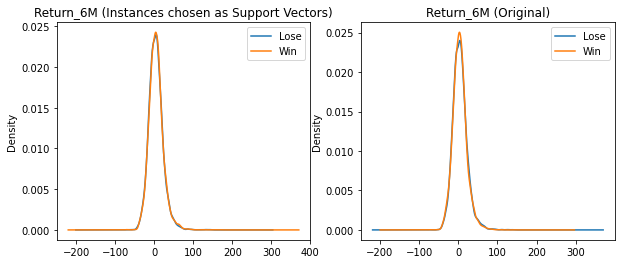

In [43]:
# now lets see the statistics of these attributes
from matplotlib import pyplot as plt
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Fwd_Return_3M_Class'])
df_grouped = X_imputed.groupby(['Fwd_Return_3M_Class'])

# plot KDE of Different variables
vars_to_plot = ['FCF_Mgn', 'Mkt_Cap', 'Best_EPS_6M', 'Best_EPS_5Y', 
               'Return_6M']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Lose','Win'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Lose','Win'])
    plt.title(v+' (Original)')


Using the graphs found above, and a few choice features, we can see how the support vectors compare to the original statistics of the data. There is not as much separation between the original distributions and the support vector distributions, which is initially odd. These graphs also show the relationships between the two and how they changed. It seems the support vecotrs tend to follow the original fairly closely, however, if the scale were to decrease between -5 and 5, we might see a very clear separation between the support vectors distribution and the original data distribution. The support vectors found on the edge of the original distributions are the instances on the edge of the class boundaries and that are incorrectly classified in the training data.

# COMPARING MODELS

Detailed below are the finalized results for our logistic regression (LR) and support vector (SVM) models based on pertinent stats:

Accuracy:  LR = 54.8% vs SVM = 59.8%

F1 Score:  LR = 58.0% vs SVM = 62.3%

AUC:  LR = 54.6% vs SVM = 59.9%

Training time:  LR = 0.25 seconds vs SVM = 229.2 seconds

Upon comparing the outputs of our models, we support the choice of the SVM as our recommended model from this analysis.  As you can see above, the performance (Accuracy, F1 score (which captures precision and recall) and Area Under the Curve (AUC)) are superior for the SVM relative to the LR model.  With this better performance comes the cost of training time / efficiency as the SVM took much longer to run / compute.  We deem this additional time (which only resulted in differential in the minutes) to be worth the cost, thus stand by our recommendation for the SVM.

In the highly competitive industry of investment management, the ability to outperform the market is extremely difficult.  The target use case for our project analyses (including this lab) is an investment manager that is picking stocks that will outperform and avoiding those that will underperform (i.e. long-only styled strategies).  Thus on the one hand, one could see the results of this analysis in a positive light given we had accuracies nearly 60% which in the investment management industry is relatively favorable.  On the other hand, we remain optimistic that we can improve upon such results and are looking forward to digging deeper into different classification techniques / algorithms in hopes that we can further improve the outputs and prediction capabilities with our dataset during forthcoming modelling analyses.